# Word2Vec

План:

* w2v from scratch
* обучаем w2v из коробки на своих данных
* используем обученный w2v и друзей

In [ ]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00


In [ ]:
!pip3 install pytorch_lightning torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 52.7 MB/s eta 0:00:00


### Импорт библиотек и загрузка данных

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl
import datasets

import nltk
nltk.download('stopwords')

import text_helper

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = datasets.load_dataset('tweets_hate_speech_detection')

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

## Вспомогательный блок

* Разбиваем тексты на токены
* Создаем словарь и другие вспомогательные характеристики по текстам
* Убираем редкие токены
* Организуем скользящее окно

Реализация в файле text_helper.py

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
dataset = dataset.map(text_helper.split_tokens) # разбиваем текст на токены

counts, vocab, n_v, id2tok, tok2id = text_helper.get_info(dataset) # получаем словарь и так далее

# counts - сколько раз встречается каждое слово в словаре
# vocab - список слов
# n_v - количество слов в словаре
# id2tok, tok2id - соответствие слов и их индексов в словаре

dataset = dataset.map(lambda x: text_helper.remove_rare_tokens(x, vocab)) # выкидываем редкие токены

dataset = dataset.map(lambda x: text_helper.windowizer(x, tok2id)) # применяем функцию скользящего окна для обучения word2vec

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

Map:   0%|          | 0/31962 [00:00<?, ? examples/s]

Map:   0%|          | 0/17197 [00:00<?, ? examples/s]

## Создаем сеть

Для работы с датасетом в PyTorch (если мы не используем стандартные датасеты, которые уже есть в библиотеке) нужно создать класс для датасета, унаследованный от torch.utils.data.Dataset с методами:
* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` - вычисление длины датасета
* `__getitem__` - доступ к объекту датасета по индексу.

In [ ]:
class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

train_dataloader = DataLoader(Word2VecDataset(dataset['train'], vocab_size=n_v),
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=N_LOADER_PROCS)

test_dataloader = DataLoader(Word2VecDataset(dataset['test'], vocab_size=n_v),
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=N_LOADER_PROCS)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


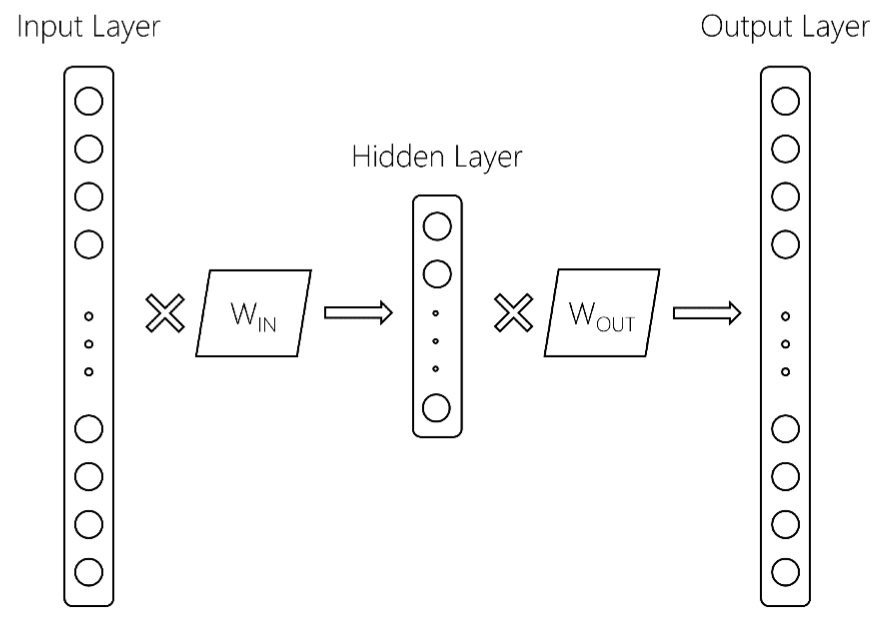

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size, bias=False)
        self.loss_func = nn.CrossEntropyLoss() # сюда встроен softmax

    def forward(self, input, target=None):
        hidden = self.embed(input)
        logits = self.linear(hidden)

        if target is not None:
            loss = self.loss_func(logits, target) # вычисляем ошибку модели
            return logits, loss

        return logits

In [ ]:
# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate) # вариант градиентного спуска, который мы используем
        return optimizer

    def training_step(self, train_batch, batch_idx): # шаг обучения: вычисляем лосс на батче
        center, context = train_batch
        _, loss = self.model(center, context)
        self.log("train_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

    def validation_step(self, val_batch, batch_idx): # шаг валидации - аналогичный; по желанию
        center, context = val_batch
        _, loss = self.model(center, context)
        self.log("val_loss", loss, prog_bar=True)  # сохраняет логи в папку
        return loss

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

EPOCHS = 25 # число эпох
LR = 0.001 # learning rate

In [ ]:
# 2) create module

EMBED_SIZE = 100 # можно и больше

model = Word2Vec(n_v, EMBED_SIZE).to(device) # объявляем сеть, переносим ее на gpu

module = SimpleModule( # объявляем модуль для обучения сети
    model,
    learning_rate=LR
)

# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer( # выбираем параметры обучения
    accelerator=accelerator,
    max_epochs=EPOCHS
)

trainer.fit(module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | Word2Vec | 617 K 
-----------------------------------
617 K     Trainable params
0         Non-trainable params
617 K     Total params
2.468     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [ ]:
wordvecs = module.model.linear.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

## Анализ результатов

* `get_distance_matrix` - функция для вычисления матрицы расстояний между векторами
* `get_k_similar_words` - функция для вычисления $k$ ближайших по косинусной метрике слов к заданному

In [ ]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric): # матрица расстояний между векторами слов
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10): # k ближайших слов к заданному
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')

for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['im', 'make', '@user', 'amp', 'one', 'today', 'go', 'see', 'great', 'thing'] 

father ['dad', 'day', '#fathersday', 'love', 'wish', 'today', 'kid', 'wonder', 'happi', 'one'] 

school ['book', 'week', 'first', 'year', 'hope', 'tomorrow', 'go', 'one', 'today', 'got'] 

hate ['peopl', 'kill', 'say', 'dont', 'even', 'know', 'would', 'much', 'sad', 'world'] 



## Обучаем готовую архитектуру на своих данных

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=dataset['train']['tokens'], vector_size=100, window=5)

In [ ]:
model.wv['father']

array([ 0.5991348 ,  1.5307833 , -0.2152086 ,  0.86048305,  1.0231751 ,
        0.13771541,  0.06933004,  1.4414669 , -1.2685513 ,  0.02089389,
       -1.1073477 , -0.6704993 ,  0.30678186,  0.11389163, -0.43920642,
       -0.20979433,  0.8237482 , -0.09468685, -1.0234973 , -1.7825462 ,
        0.64215934, -0.21077724, -0.6100512 , -1.336692  ,  0.21552263,
       -0.40493828, -0.6196255 ,  0.01987981, -0.6473436 ,  1.4248852 ,
        1.4425566 , -0.20710507, -0.5093619 , -0.23715657, -0.2806002 ,
        1.779688  ,  1.004682  ,  0.92930865,  1.0055497 , -1.213095  ,
        0.8162243 , -0.7290115 ,  0.4745563 ,  0.01251323,  0.15929645,
       -0.3327895 ,  0.01199763, -0.13308813,  0.3807084 , -0.15314314,
        0.7670963 , -0.84656614, -0.6288423 ,  0.6877901 , -0.35368112,
       -0.24904147,  0.14035924, -0.5261756 , -0.8458478 ,  0.28945243,
        0.16344641,  0.6782234 ,  0.7392696 , -0.8562551 , -0.96536   ,
        0.44798255,  0.3445705 ,  0.06824213, -1.019818  , -0.30

In [ ]:
model.wv.most_similar('father', topn=10)

[('dad', 0.9920458793640137),
 ('#fathersday', 0.9331070780754089),
 ('daddi', 0.9247403144836426),
 ('wish', 0.9205994009971619),
 ('bless', 0.9161788821220398),
 ('papa', 0.9160575866699219),
 ('#father', 0.9104456901550293),
 ('day', 0.9093515872955322),
 ('fathersday', 0.9020785689353943),
 ('gift', 0.9016363024711609)]

## Используем предобученные модели

In [ ]:
import gensim.downloader

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2v_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
w2v_vectors['father']

array([-1.2006  ,  0.59454 ,  0.27821 ,  0.86424 ,  0.021296, -1.1184  ,
        1.1299  ,  0.26826 , -0.41652 , -0.22056 ,  0.203   ,  0.57734 ,
       -3.8551  ,  0.58745 , -0.21923 , -0.30499 ,  0.75124 ,  0.31219 ,
        0.29848 , -0.43404 ,  1.0534  ,  0.85965 , -0.90158 , -0.47079 ,
       -0.37878 ], dtype=float32)

In [ ]:
w2v_vectors.most_similar('father')

[('mother', 0.9509678483009338),
 ('daughter', 0.9483673572540283),
 ('husband', 0.9278267025947571),
 ('child', 0.9260582327842712),
 ('wife', 0.924705445766449),
 ('whose', 0.9104862809181213),
 ('grandmother', 0.9046282172203064),
 ('woman', 0.9028053879737854),
 ('birth', 0.8912784457206726),
 ('called', 0.8850919008255005)]

In [ ]:
new_vector = w2v_vectors['queen'] - w2v_vectors['woman'] + w2v_vectors['man']

In [ ]:
w2v_vectors.most_similar(positive=[new_vector])

[('nat', 0.8628743290901184),
 ('man', 0.8274872899055481),
 ('tom', 0.8135091066360474),
 ('val', 0.7990007996559143),
 ('omg', 0.79527747631073),
 ('ken', 0.7896934747695923),
 ('boom', 0.7883124947547913),
 ('bam', 0.7844099402427673),
 ('nina', 0.7789903283119202),
 ('miss', 0.7762444019317627)]